In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
DATA_DIR = 'E:\\few_data\\few_data\\'
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

(512, 1120, 1)


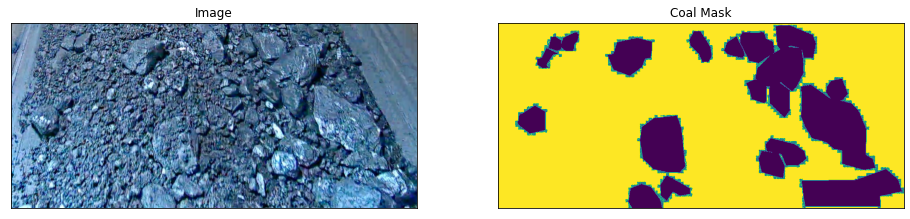

In [2]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
class Dataset(BaseDataset):

    CLASSES = ['coal']

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i],0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)
dataset = Dataset(x_train_dir, y_train_dir, classes=['coal'])

image, mask = dataset[0] # get some sample
print(mask.shape)
visualize(
    image=image,
    coal_mask=mask[..., 0].squeeze(),
)

In [3]:
import albumentations as albu
import torch
import numpy as np
import segmentation_models_pytorch as smp
def get_training_augmentation():
    train_transform = [
        albu.Resize(512,512),
        albu.HorizontalFlip(p=0.5),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(512,512),

    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [4]:
ENCODER = 'resnext101_32x8d'
ENCODER_WEIGHTS = 'instagram'
CLASSES = ['coal']
ACTIVATION = 'sigmoid'
DEVICE = 'cuda'
aux_params=dict(
    pooling='avg',             # one of 'avg', 'max'
    dropout=0.5,               # dropout ratio, default is None
    activation='sigmoid',      # activation function, default is None
    classes=1,
)
# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
    #aux_params=aux_params
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
print(preprocessing_fn)

functools.partial(<function preprocess_input at 0x00000131525D97B8>, input_space='RGB', input_range=[0, 1], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


In [5]:
train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True)

In [6]:
from segmentation_models_pytorch import utils
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

In [7]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=torch.device("cuda"),
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=torch.device("cuda"),
    verbose=True,
)

In [8]:
max_score = 0

for i in range(0, 10):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model3.pth')
        print('Model saved!')


Epoch: 0
valid: 100%|██████████| 3/3 [00:00<00:00, 10.56it/s, dice_loss - 0.1124, iou_score - 0.7984]
Model saved!

Epoch: 1
valid: 100%|██████████| 3/3 [00:00<00:00, 11.36it/s, dice_loss - 0.09925, iou_score - 0.8203]
Model saved!

Epoch: 2
valid: 100%|██████████| 3/3 [00:00<00:00, 10.93it/s, dice_loss - 0.08988, iou_score - 0.8361]
Model saved!

Epoch: 3
valid: 100%|██████████| 3/3 [00:00<00:00, 11.36it/s, dice_loss - 0.06877, iou_score - 0.8734]
Model saved!

Epoch: 4
valid: 100%|██████████| 3/3 [00:00<00:00, 11.90it/s, dice_loss - 0.06195, iou_score - 0.8857]
Model saved!

Epoch: 5
valid: 100%|██████████| 3/3 [00:00<00:00, 11.97it/s, dice_loss - 0.05845, iou_score - 0.8922]
Model saved!

Epoch: 6
valid: 100%|██████████| 3/3 [00:00<00:00, 12.39it/s, dice_loss - 0.0537, iou_score - 0.9014]
Model saved!

Epoch: 7
valid: 100%|██████████| 3/3 [00:00<00:00, 12.14it/s, dice_loss - 0.05859, iou_score - 0.8929]

Epoch: 8
valid: 100%|██████████| 3/3 [00:00<00:00, 10.71it/s, dice_loss - 0.05

In [9]:
best_model = torch.load('./best_model3.pth')
best_model.eval()
test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 512, 512])
torch.Size([1, 1, 512, 512])
(512, 512, 1)


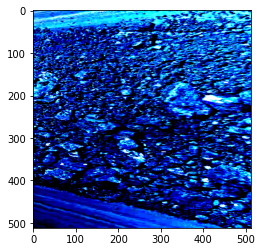

In [10]:
i=50
image, gt_mask = test_dataset[0]
gt_mask = gt_mask.squeeze()
orig = image.copy()

#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
x_tensor = torch.from_numpy(image).to('cuda').unsqueeze(0)
image = image.transpose(2, 1, 0).astype('float32')

print(x_tensor.shape)
pr_mask = best_model.predict(x_tensor)

print(pr_mask.shape)
norm = ((pr_mask.squeeze(0).cpu().numpy())*255).astype(dtype=np.uint8)
norm = norm.transpose(1, 2, 0).astype('uint8')
print(norm.shape)
plt.imshow(norm)
plt.imshow(image)
norm1 = cv2.cvtColor(norm, cv2.COLOR_GRAY2RGB)

In [11]:
best_model = torch.load('./best_model3.pth')
best_model.eval()
image = cv2.imread(r"E:\few_data\few_data\test\20210712_141048_857A_ACCC8EAF31F3_540.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
orig = image.copy().astype('float32')
trf = albu.Compose([albu.Lambda(image=preprocessing_fn)])
image = trf(image=image)['image']
image = cv2.resize(image,(512,512))

image = image.transpose(2, 0, 1).astype('float32')

x_tensor = torch.from_numpy(image).to('cuda').unsqueeze(0)
pr_mask = best_model.predict(x_tensor)

pr_mask1 = ((pr_mask.squeeze(0).cpu().numpy())*255).transpose(1, 2, 0)
image = image.transpose(1, 2, 0)

cv2.imwrite(r"E:\few_data\few_data\test\predicted_540.jpg",pr_mask1)
test = pr_mask.squeeze(0).cpu().numpy()
test = test.transpose(1, 2,0)
test = cv2.cvtColor(test, cv2.COLOR_GRAY2RGB)
test = cv2.resize(test,(1120,512))

test = 1.0-test
print(orig.shape)
print(test.shape)
foreground = cv2.multiply(orig, test)

cv2.imwrite(r"E:\few_data\few_data\test\predicted_res.jpg",foreground)


(512, 1120, 3)
(512, 1120, 3)


True